In [1]:
import os
import sys

root_dir = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
model_dir = os.path.join(root_dir, "model")
sys.path.append(root_dir)
sys.path.append(model_dir)

import time
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hoho_utils
import hoho_config


plt.style.use('ggplot')

In [2]:
def suffix_time():
    current_time = time.time()
    local_time = time.localtime(current_time)
    time_str = time.strftime('%Y%m%d%H%M%S', local_time)
    return time_str

In [3]:
suffix = suffix_time()
suffix

'20230922021646'

### 加载走子数据

In [6]:
data_dir = "../output/data"
file_list = os.listdir(data_dir)
file_count = len(file_list)
item_list = list()
expect_files = []

for i, filename in enumerate(file_list):
    if not filename.startswith(hoho_config.REPLAY_BUFFER_FILE_PREFIX):
        continue
    expect_files.append(filename)
    
    
print(f"file_count: {len(expect_files)}")

for i, filename in enumerate(expect_files):
    file_path = os.path.join(data_dir, filename)
    print(file_path)
    with open(file_path, "r") as file:
        json_str = file.read()
        matches = json.loads(json_str)
        match_count = len(matches)

        for j, match in enumerate(matches):
            base_id =  int(time.time() * 1000) + j
            for k, round in enumerate(match):
                match_id = f"{i}-{j}"
                round_id = f"{base_id}-{k}"
                state = round[0]
                action = round[2]
                next_state = round[3]
                raw_reward = round[4]
                done = round[5]
                chapture_list = round[6]
                chaptures = ','.join(chapture_list)
                chapture_reward = round[7]
                re_reward = round[8]

                round_dict = {"match_id": match_id,
                              "round_id": round_id,
                              "state": state,
                              "action":action,
                              "next_state": next_state,
                              "done": done,
                              "chaptures": chaptures,
                              "chapture_reward": chapture_reward,
                              "raw_reward": raw_reward,
                              "re_reward": re_reward}
                item_list.append(round_dict)

                if done:
                    break

file_count: 3
../output/data\D3QNAB_1695305088_25.json
../output/data\D3QNAB_1695309317_90.json
../output/data\D3QNAB_1695315693_189.json


In [7]:
data = pd.DataFrame(item_list)

In [8]:
data

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,raw_reward,re_reward
0,0-0,1695320290718-0,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,c3c4,RNBAKABcR/9/1C5C1/P3P1P1P/2P6/9/p1p1p1p1p/1c7/...,False,N,-2.00,0,-6.9139
1,0-0,1695320290718-1,RNBAKABcR/9/1C5C1/P3P1P1P/2P6/9/p1p1p1p1p/1c7/...,h2h7,RNBAKcB1R/9/1C7/P3P1P1P/2P6/9/p1p1p1p1p/1c5C1/...,False,A,-0.71,0,-88.3000
2,0-0,1695320290718-2,RNBAKcB1R/9/1C7/P3P1P1P/2P6/9/p1p1p1p1p/1c5C1/...,h7g7,RNBAK1B1c/9/1C7/P3P1P1P/2P6/9/p1p1p1p1p/1c4C2/...,False,R,-4.29,0,-97.1200
3,0-0,1695320290718-3,RNBAK1B1c/9/1C7/P3P1P1P/2P6/9/p1p1p1p1p/1c4C2/...,b2c2,RNBAc1B2/9/2C6/P3P1P1P/2P6/9/p1p1p1p1p/1c4C2/9...,True,K,-100.00,-1,-95.4361
4,0-1,1695320290719-0,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,h2h6,RNBAKABcR/9/1C7/P1P1P1P1P/9/9/p1p1p1pCp/1c7/9/...,False,N,-2.00,0,-1.5841
...,...,...,...,...,...,...,...,...,...,...
1040,2-49,1695320291158-1,RNBAKAB1R/9/1C5CN/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,b2d2,RNBAKAB1R/9/3C3CN/P1P1c1P1P/9/9/p1p1p1p1p/1c7/...,False,P,-1.00,0,-6.2749
1041,2-49,1695320291158-2,RNBAKAB1R/9/3C3CN/P1P1c1P1P/9/9/p1p1p1p1p/1c7/...,d2b2,RNBAKAB1R/9/1C5CN/P1P3P1c/9/9/p1p1p1p1p/1c7/9/...,False,P,-1.00,0,-6.6610
1042,2-49,1695320291158-3,RNBAKAB1R/9/1C5CN/P1P3P1c/9/9/p1p1p1p1p/1c7/9/...,b2d2,RNBAKAB1c/9/3C3CN/P1P3P2/9/9/p1p1p1p1p/1c7/9/r...,False,R,-4.29,0,-87.5710
1043,2-49,1695320291158-4,RNBAKAB1c/9/3C3CN/P1P3P2/9/9/p1p1p1p1p/1c7/9/r...,d2b2,RNBAKAB1c/9/1C5CN/P1P3P2/9/9/p1p1p1p1p/4c4/9/r...,False,,0.00,0,-95.6710


In [9]:
data.to_excel(f"./outputs/hoho_chess_data_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.xlsx", index = False)

### 看看随着模型不断学习升级，累积奖励的趋势

In [10]:
data_group = data.groupby(["match_id"], as_index = False).agg({"re_reward": sum, "chapture_reward": sum, "round_id": "count"})
data_group.rename(columns = {"round_id": "step_count"}, inplace = True)
data_group

,match_id,re_reward,chapture_reward,step_count
0,0-0,-287.7700,-107.00,4
1,0-1,-283.4749,-104.00,10
2,0-10,-287.7700,-107.00,4
3,0-11,-287.7700,-107.00,4
4,0-12,-185.6000,-102.00,2
...,...,...,...,...
145,2-5,-294.3097,-106.58,7
146,2-6,-280.4028,-103.29,6
147,2-7,-270.2669,-101.29,5
148,2-8,-376.6991,-122.45,23


In [11]:
data_group["match_id1"] = data_group["match_id"].apply(lambda x: x.split("-")[0]).astype(int)
data_group["match_id2"] = data_group["match_id"].apply(lambda x: x.split("-")[-1]).astype(int)
data_group

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,0-0,-287.7700,-107.00,4,0,0
1,0-1,-283.4749,-104.00,10,0,1
2,0-10,-287.7700,-107.00,4,0,10
3,0-11,-287.7700,-107.00,4,0,11
4,0-12,-185.6000,-102.00,2,0,12
...,...,...,...,...,...,...
145,2-5,-294.3097,-106.58,7,2,5
146,2-6,-280.4028,-103.29,6,2,6
147,2-7,-270.2669,-101.29,5,2,7
148,2-8,-376.6991,-122.45,23,2,8


In [12]:
data_group_sorted = data_group.sort_values(by = "match_id1")
data_group_sorted

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,0-0,-287.7700,-107.00,4,0,0
27,0-33,-294.0900,-108.00,6,0,33
28,0-34,-288.7700,-107.00,5,0,34
29,0-35,-287.7700,-107.00,4,0,35
30,0-36,-319.7056,-110.58,13,0,36
...,...,...,...,...,...,...
119,2-26,-380.2412,-123.16,20,2,26
120,2-27,-290.0428,-105.29,7,2,27
121,2-28,-315.0677,-110.29,11,2,28
111,2-19,-280.7500,-105.00,4,2,19


In [13]:
data_group_sorted2 = data_group_sorted.groupby("match_id1").apply(lambda x: x.sort_values(by = "match_id2"))
data_group_sorted3 = data_group_sorted2.reset_index(drop = True)

In [14]:
data_group_sorted3

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,0-0,-287.7700,-107.00,4,0,0
1,0-1,-283.4749,-104.00,10,0,1
2,0-2,-275.6121,-102.71,6,0,2
3,0-3,-287.7700,-107.00,4,0,3
4,0-4,-282.5500,-105.00,4,0,4
...,...,...,...,...,...,...
145,2-45,-287.7700,-107.00,4,2,45
146,2-46,-368.2812,-120.16,21,2,46
147,2-47,-323.4684,-111.87,12,2,47
148,2-48,-294.1056,-105.58,9,2,48


In [16]:
data_group_sorted3.to_excel(f"./outputs/hoho_ddqn_total_rewards_data_by_match_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.xlsx", index = False)

In [17]:
def smooth_plot(val_list):
    result_list = []
    current_val = 0
    for i, val in enumerate(val_list):
        current_val = val * 0.05 + 0.95 * current_val
        result_list.append(current_val)
    return result_list

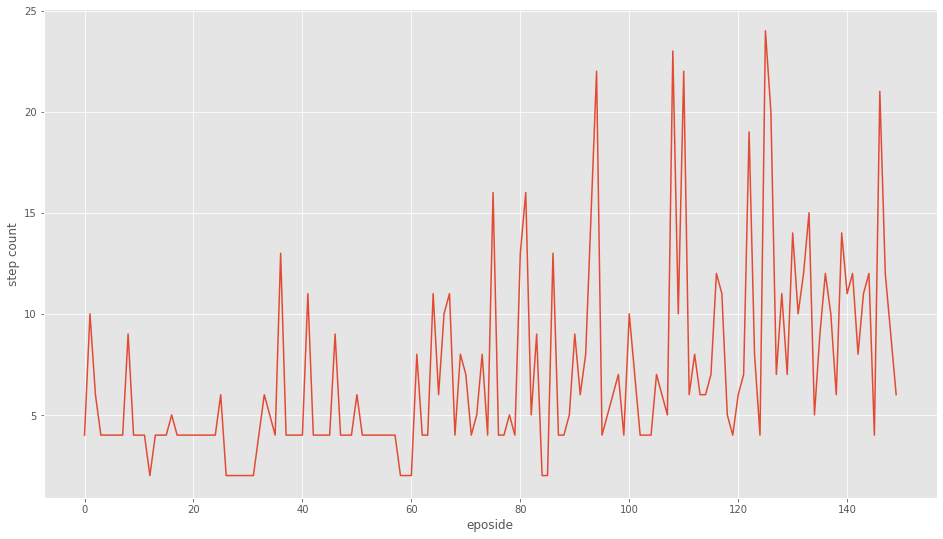

In [19]:
### 对战步数
plt.figure(figsize = (16, 9))
x = range(data_group_sorted3["step_count"].values.shape[0])
y = data_group_sorted3["step_count"].values
plt.xlabel("eposide")
plt.ylabel("step count")
plt.plot(x, y)
plt.savefig(f"./outputs/images/step_count_1_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

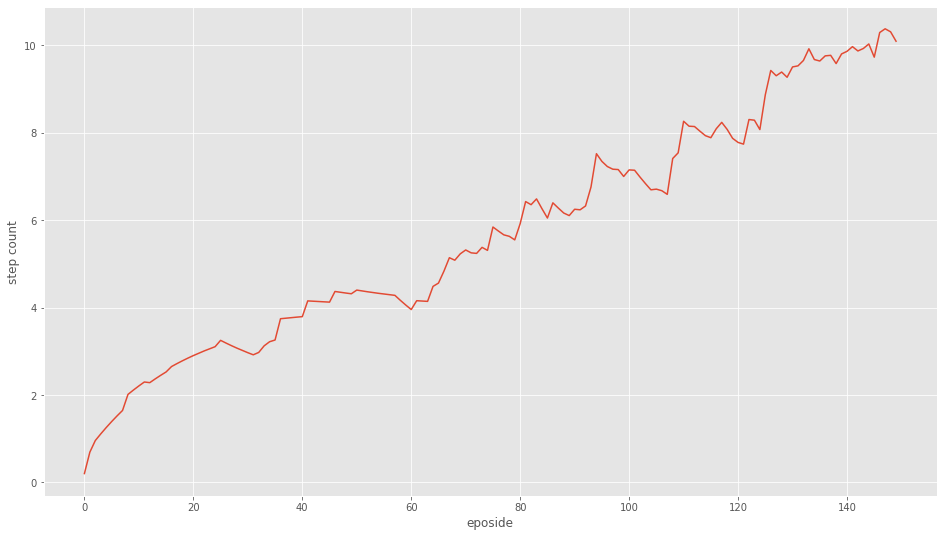

In [20]:
# 做一下平滑

y = smooth_plot(data_group_sorted3["step_count"].values)
x = range(len(y))
plt.figure(figsize = (16, 9))
plt.xlabel("eposide")
plt.ylabel("step count")
plt.plot(x, y)
plt.savefig(f"./outputs/images/step_count_2_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

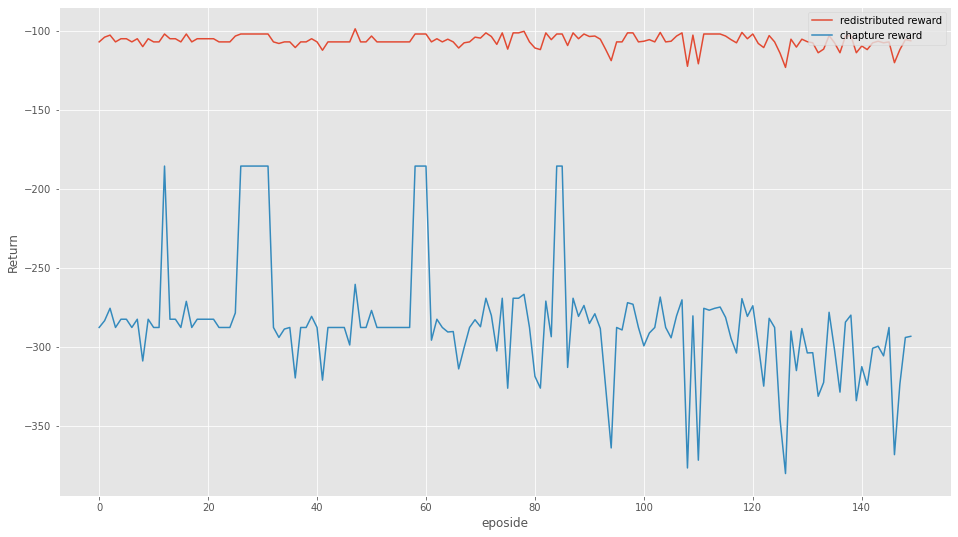

In [22]:
### 累积奖励
plt.figure(figsize = (16, 9))
x = range(data_group_sorted3["chapture_reward"].values.shape[0])
y1 = data_group_sorted3["chapture_reward"].values
y2 = data_group_sorted3["re_reward"].values
plt.xlabel("eposide")
plt.ylabel("Return")
plt.plot(x, y1, label = "redistributed reward")
plt.plot(x, y2, label = "chapture reward")
plt.legend(loc = "upper right")
plt.savefig(f"./outputs/images/return_1_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

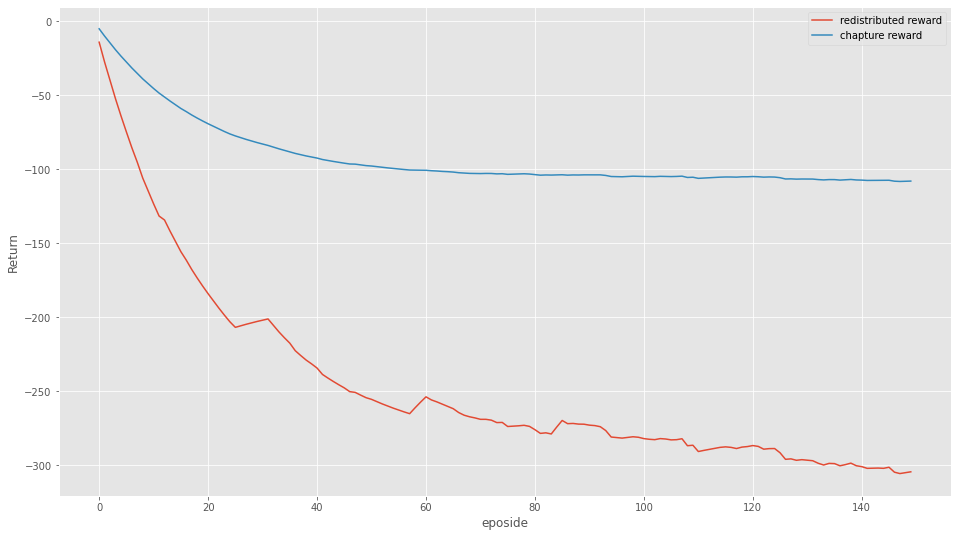

In [23]:
# 平滑处理
y1 = smooth_plot(data_group_sorted3["re_reward"].values)
y2 = smooth_plot(data_group_sorted3["chapture_reward"].values)
x = range(len(y1))
plt.figure(figsize = (16, 9))
plt.xlabel("eposide")
plt.ylabel("Return")
plt.plot(x, y1, label = "redistributed reward")
plt.plot(x, y2, label = "chapture reward")
plt.legend(loc = "upper right")
plt.savefig(f"./outputs/images/return_2_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

In [24]:
data_group_sorted3["avg_chapture_reward"] = data_group_sorted3["chapture_reward"] / data_group_sorted3["step_count"]
data_group_sorted3["avg_re_reward"] = data_group_sorted3["re_reward"] / data_group_sorted3["step_count"]
data_group_sorted3

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2,avg_chapture_reward,avg_re_reward
0,0-0,-287.7700,-107.00,4,0,0,-26.750000,-71.94250
1,0-1,-283.4749,-104.00,10,0,1,-10.400000,-28.34749
2,0-2,-275.6121,-102.71,6,0,2,-17.118333,-45.93535
3,0-3,-287.7700,-107.00,4,0,3,-26.750000,-71.94250
4,0-4,-282.5500,-105.00,4,0,4,-26.250000,-70.63750
...,...,...,...,...,...,...,...,...
145,2-45,-287.7700,-107.00,4,2,45,-26.750000,-71.94250
146,2-46,-368.2812,-120.16,21,2,46,-5.721905,-17.53720
147,2-47,-323.4684,-111.87,12,2,47,-9.322500,-26.95570
148,2-48,-294.1056,-105.58,9,2,48,-11.731111,-32.67840


In [25]:
data_group_sorted3.to_excel(f"./outputs/hoho_avg-chapture-reward_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.xlsx")

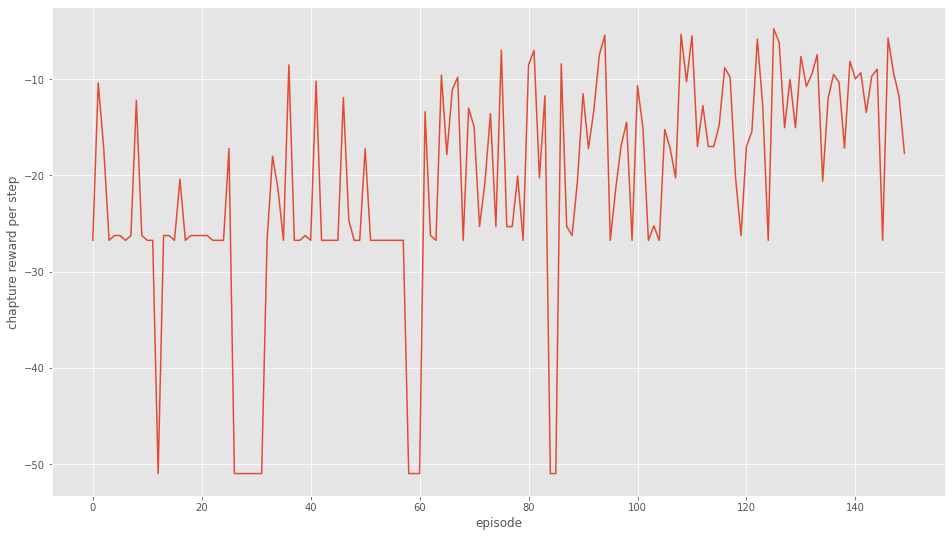

In [26]:
x = range(data_group_sorted3["avg_chapture_reward"].values.shape[0])
y = data_group_sorted3["avg_chapture_reward"].values
plt.figure(figsize = (16, 9))
plt.plot(x, y)
plt.xlabel("episode")
plt.ylabel("chapture reward per step")
# plt.show()
plt.savefig(f"./outputs/images/chapture_reward_per_step_1_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

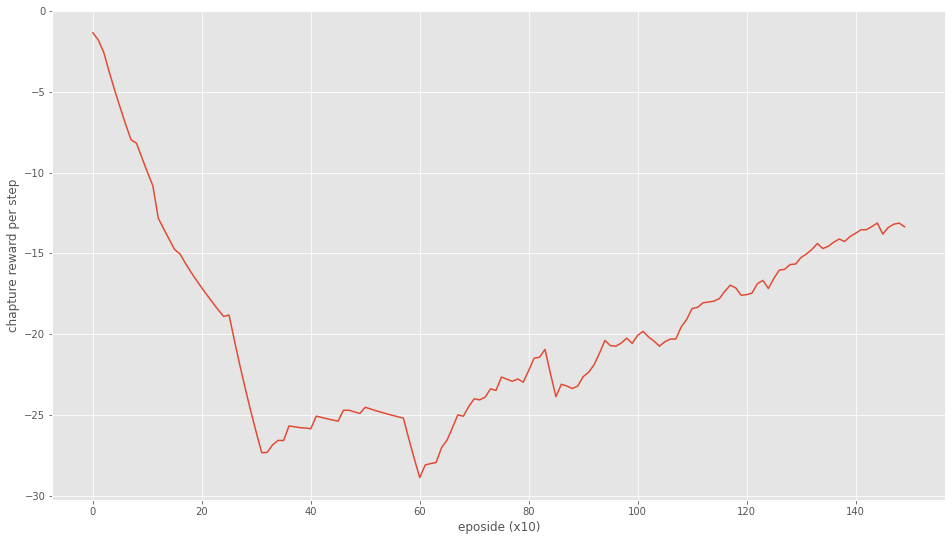

In [27]:
# 做一下平滑1

y = smooth_plot(data_group_sorted3["avg_chapture_reward"].values)
x = range(len(y))

plt.figure(figsize = (16, 9))
plt.xlabel("eposide (x10)")
plt.ylabel("chapture reward per step")
plt.plot(x, y)
plt.savefig(f"./outputs/images/chapture_reward_per_step_2_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

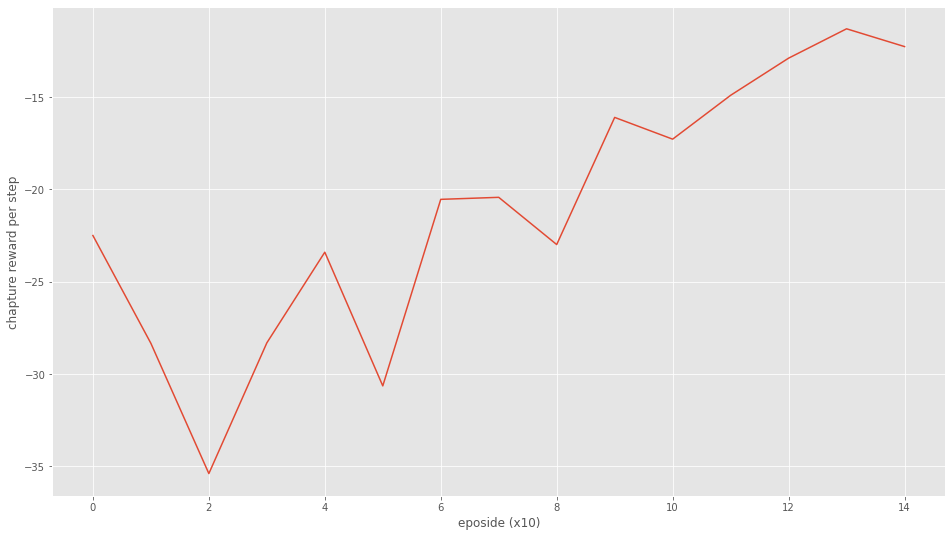

In [28]:
# 做一下平滑2
avg_count_list = []
avg_crewards = data_group_sorted3["avg_chapture_reward"].values.tolist()
for i, val in enumerate(avg_crewards):
    if (i + 1) % 10 == 0:
        avg_val = np.mean(avg_crewards[(i + 1 - 10): (i + 1)])
        avg_count_list.append(avg_val)

plt.figure(figsize = (16, 9))
plt.xlabel("eposide (x10)")
plt.ylabel("chapture reward per step")
plt.plot(range(len(avg_count_list)), avg_count_list)
plt.savefig(f"./outputs/images/chapture_reward_per_step_3_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.png")

### 分配奖励到指定棋局(Double DQN Learning)

In [27]:
data_demo1 = data[data["match_id"] == "48-7"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
2034,b2d2,False,,0.00,0,-2.0449
2035,d2a2,False,,0.00,0,-2.9710
2036,a2a6,False,"C,p",-1.29,0,-3.8710
2037,h2d2,False,P,-1.00,0,-2.8000
2038,d2a2,False,P,-1.00,0,-5.3749
2039,c3c4,False,,0.00,0,-6.4810
2040,a2e2,False,R,-4.29,0,-6.6610
2041,c4c5,False,N,-2.00,0,-2.8000
2042,i0i1,False,,0.00,0,-1.0000
2043,c5d5,False,,0.00,0,-4.4749


In [28]:
data_demo1["raw_reward"] = [-1] * len(data_demo1)
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
2034,b2d2,False,,0.00,-1,-2.0449
2035,d2a2,False,,0.00,-1,-2.9710
2036,a2a6,False,"C,p",-1.29,-1,-3.8710
2037,h2d2,False,P,-1.00,-1,-2.8000
2038,d2a2,False,P,-1.00,-1,-5.3749
2039,c3c4,False,,0.00,-1,-6.4810
2040,a2e2,False,R,-4.29,-1,-6.6610
2041,c4c5,False,N,-2.00,-1,-2.8000
2042,i0i1,False,,0.00,-1,-1.0000
2043,c5d5,False,,0.00,-1,-4.4749


In [29]:
data_demo2 = data[data["match_id"] == "10-8"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo2["raw_reward"] = [-1] * len(data_demo2)
data_demo2

,action,done,chaptures,chapture_reward,raw_reward,re_reward


### 分配奖励到指定棋局(LSTM-Attention)

In [5]:
file_path = "./outputs/hoho_chess_data_20230905213354.xlsx"
chess_data = pd.read_excel(file_path)

In [6]:
contribution_file = "./outputs/hoho_action_contribution_maxstep15_win-lose-1_20230905213354.xlsx"
contribution_data = pd.read_excel(contribution_file)
contribution_data

,action_type,contribution
0,a0b0,0.065608
1,a0c0,0.061905
2,a0d0,0.000000
3,a0e0,0.000000
4,a0f0,0.000000
...,...,...
2081,e7c9,0.000000
2082,e7g5,0.000000
2083,g5e7,0.000000
2084,g9i7,0.000000


In [67]:
win = -1 # 赢为1，输为-1
hoho_match_data = chess_data[chess_data["match_id"] == "82-7"].copy()  # 随便选一场输的看看
actions_list = hoho_match_data["action"].values
hoho_match_contribution_data = contribution_data[contribution_data["action_type"].isin(actions_list)].copy()
total_contribution = hoho_match_contribution_data["contribution"].sum()
hoho_match_contribution_data["mine"] = hoho_match_contribution_data["contribution"].apply(lambda c: c / total_contribution * (len(hoho_match_contribution_data) * win))
hoho_match_contribution_data["alphago_zero"] = len(hoho_match_contribution_data) * [win]

In [68]:
hoho_match_contribution_data2 = hoho_match_contribution_data.rename(columns = {"action_type": "action"})

In [69]:
hoho_match_contribution_data2

,action,contribution,mine,alphago_zero
0,a0b0,0.065608,-1.088780,-1
8,a0a1,0.066551,-1.104414,-1
20,a1c1,0.065753,-1.091186,-1
204,b0a0,0.063889,-1.060244,-1
212,b0b1,0.055556,-0.921951,-1
223,b0c2,0.066449,-1.102728,-1
226,b1d1,0.044444,-0.737561,-1
253,b2b0,0.062500,-1.037195,-1
693,d1d3,0.044444,-0.737561,-1
904,e0f0,0.065432,-1.085853,-1


In [70]:
match_data_merge = pd.merge(hoho_match_data, hoho_match_contribution_data2, on = "action", how = "left")

In [71]:
match_data_merge

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,win,converted,jid,contribution,mine,alphago_zero
0,82-7,16939208404300,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,b0c2,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5...,0,NaN,0.00,0,0,82-7_16939208404300,0.066449,-1.102728,-1
1,82-7,16939208404301,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,h2h8,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404301,0.063492,-1.053659,-1
2,82-7,16939208404302,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,b2b0,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,0,C,-25.41,0,0,82-7_16939208404302,0.062500,-1.037195,-1
3,82-7,16939208404303,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,c0a2,RC1AKABNR/9/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404303,0.066516,-1.103845,-1
4,82-7,16939208404304,RC1AKABNR/7r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,a0a1,1C1AKABNR/R6r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c...,0,NaN,0.00,0,0,82-7_16939208404304,0.066551,-1.104414,-1
5,82-7,16939208404305,1C1AKABNR/Rc5r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/4...,f0e1,1C1AK1BNR/Rc2A2r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p...,0,NaN,0.00,0,0,82-7_16939208404305,0.066664,-1.106300,-1
6,82-7,16939208404306,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P1P/9/9/p1p1p1p1p/...,i3i4,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404306,0.066502,-1.103602,-1
7,82-7,16939208404307,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0a0,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404307,0.063889,-1.060244,-1
8,82-7,16939208404308,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,a0b0,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404308,0.065608,-1.088780,-1
9,82-7,16939208404309,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0b1,3AK1BNR/RC2A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404309,0.055556,-0.921951,-1


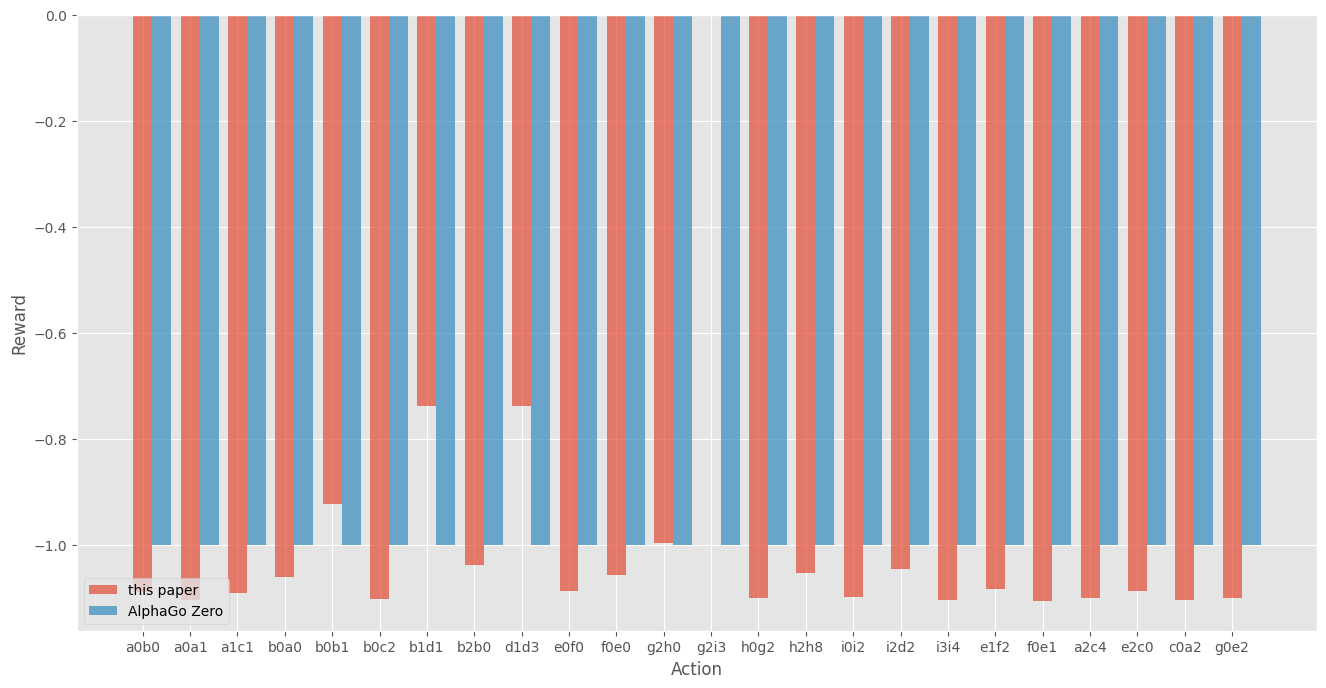

In [72]:
custom_ticks = list(range(len(hoho_match_contribution_data)))
custom_labels = hoho_match_contribution_data2["action"].values.tolist()
plt.figure(figsize = (16, 8))
plt.bar(range(len(hoho_match_contribution_data)), hoho_match_contribution_data["mine"], width=0.4, alpha=0.7, label='this paper' )
plt.bar([i + 0.4 for i in range(len(hoho_match_contribution_data))], hoho_match_contribution_data["alphago_zero"], width=0.4, alpha=0.7, label='AlphaGo Zero'  )
plt.xticks(custom_ticks, custom_labels)
plt.xlabel('Action')
plt.ylabel('Reward')
plt.legend(loc='lower left')
plt.show()